# Main Character Gender Prediction

Predicting the gender of a main character based on textual data, such as movie reviews, is an interesting and practical problem in Natural Language Processing. This project, “Main Character Gender Prediction”, aims to build a machine learning models (and choose which one is the best) that can classify whether the main character of a given work is male or female, using the textual content of user-generated reviews as the primary data source.

In [2]:
#Loading the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import spacy
from sklearn.svm import LinearSVC
from sklearn.feature_extraction import text
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer

In [3]:
#Loading the dataset
movie_revs = pd.read_csv('movie_reviews.csv')

In [4]:
movie_revs.head()

,Unnamed: 0,review_id,movie_name,year,reviewer_name,review_text,rated,year_api,genre,directors,writers,actors,plot,first_genre,first_actor,first_director,first_writer,first_actor_gender,first_director_gender,first_writer_gender
0,0,1,Lethal Weapon 3,1992.0,J. Boyajian,"About 20 minutes into LETHAL WEAPON 3, my neph...",R,1992,"Action, Crime, Thriller",Richard Donner,"Jeffrey Boam, Robert Mark Kamen, Shane Black","Mel Gibson, Danny Glover, Joe Pesci",Martin Riggs and Roger Murtaugh pursue a forme...,Action,Mel Gibson,Richard Donner,Jeffrey Boam,female,male,male
1,1,2,Lethal Weapon 3,1999.0,Frank Maloney,LETHAL WEAPON 3 is a film directed by Richard ...,R,1992,"Action, Crime, Thriller",Richard Donner,"Jeffrey Boam, Robert Mark Kamen, Shane Black","Mel Gibson, Danny Glover, Joe Pesci",Martin Riggs and Roger Murtaugh pursue a forme...,Action,Mel Gibson,Richard Donner,Jeffrey Boam,female,male,male
2,2,3,Lethal Weapon 3,1995.0,Brian L.,"120 min., R, Comedy/Action, 1992\nDirector: Ri...",R,1992,"Action, Crime, Thriller",Richard Donner,"Jeffrey Boam, Robert Mark Kamen, Shane Black","Mel Gibson, Danny Glover, Joe Pesci",Martin Riggs and Roger Murtaugh pursue a forme...,Action,Mel Gibson,Richard Donner,Jeffrey Boam,female,male,male
3,3,4,Lethal Weapon 3,1979.0,Mark Santora,It has been a couple of years since we last sa...,R,1992,"Action, Crime, Thriller",Richard Donner,"Jeffrey Boam, Robert Mark Kamen, Shane Black","Mel Gibson, Danny Glover, Joe Pesci",Martin Riggs and Roger Murtaugh pursue a forme...,Action,Mel Gibson,Richard Donner,Jeffrey Boam,female,male,male
4,4,5,Lethal Weapon 3,1997.0,Jose R.,I went to this movie with very low expectation...,R,1992,"Action, Crime, Thriller",Richard Donner,"Jeffrey Boam, Robert Mark Kamen, Shane Black","Mel Gibson, Danny Glover, Joe Pesci",Martin Riggs and Roger Murtaugh pursue a forme...,Action,Mel Gibson,Richard Donner,Jeffrey Boam,female,male,male


## Data Preprocessing

In [5]:
#Checking some information about dataset
movie_revs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18862 entries, 0 to 18861
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             18862 non-null  int64  
 1   review_id              18862 non-null  int64  
 2   movie_name             18862 non-null  object 
 3   year                   18491 non-null  float64
 4   reviewer_name          18862 non-null  object 
 5   review_text            18862 non-null  object 
 6   rated                  17201 non-null  object 
 7   year_api               18862 non-null  int64  
 8   genre                  18855 non-null  object 
 9   directors              18532 non-null  object 
 10  writers                17909 non-null  object 
 11  actors                 18647 non-null  object 
 12  plot                   18214 non-null  object 
 13  first_genre            18855 non-null  object 
 14  first_actor            18647 non-null  object 
 15  fi

In [6]:
#How many columns is null in the dataset
movie_revs.isnull().sum(axis=0)

Unnamed: 0                  0
review_id                   0
movie_name                  0
year                      371
reviewer_name               0
review_text                 0
rated                    1661
year_api                    0
genre                       7
directors                 330
writers                   953
actors                    215
plot                      648
first_genre                 7
first_actor               215
first_director            330
first_writer              953
first_actor_gender          0
first_director_gender       0
first_writer_gender         0
dtype: int64

In [7]:
#Removing unnecessary column
movie_revs.drop(columns=['Unnamed: 0'], inplace=True, errors='ignore')

#Deleting rows that have 'unknown' value in a first_actor_gender column
movie_revs = movie_revs[movie_revs['first_actor_gender'] != 'unknown'].copy()

In [8]:
#Changing name of the year_api and year column
movie_revs.rename(columns={'year_api': 'year_of_production', 'year': 'year_of_opinion'}, inplace=True)
movie_revs.columns

Index(['review_id', 'movie_name', 'year_of_opinion', 'reviewer_name',
       'review_text', 'rated', 'year_of_production', 'genre', 'directors',
       'writers', 'actors', 'plot', 'first_genre', 'first_actor',
       'first_director', 'first_writer', 'first_actor_gender',
       'first_director_gender', 'first_writer_gender'],
      dtype='object')

In [9]:
#Set the type of year_of_opinion as integer
movie_revs['year_of_opinion'] = movie_revs['year_of_opinion'].astype('Int64')
movie_revs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17652 entries, 0 to 18861
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   review_id              17652 non-null  int64 
 1   movie_name             17652 non-null  object
 2   year_of_opinion        17290 non-null  Int64 
 3   reviewer_name          17652 non-null  object
 4   review_text            17652 non-null  object
 5   rated                  16459 non-null  object
 6   year_of_production     17652 non-null  int64 
 7   genre                  17647 non-null  object
 8   directors              17429 non-null  object
 9   writers                16938 non-null  object
 10  actors                 17652 non-null  object
 11  plot                   17218 non-null  object
 12  first_genre            17647 non-null  object
 13  first_actor            17652 non-null  object
 14  first_director         17429 non-null  object
 15  first_writer           1

In [10]:
#Fast chech whether review_id column has all unique values
print(len(movie_revs['review_id']))
print(movie_revs['review_id'].nunique())

17652
17652


In [11]:
#Filling 'unidentified' in columns rated, genre and first_genre for possibly future charts
to_fill = {'rated': 'unidentified',
          'genre': 'unidentified',
          'first_genre': 'unidentified'
          }

movie_revs.fillna(value=to_fill, inplace=True)

In [12]:
# This function cleans text by converting it to lowercase, removing HTML tags,
# removing all characters that are not letters or spaces, 
#and replacing multiple consecutive spaces with a single space.
def basic_cleaning(txt):
    txt = txt.lower()
    txt = re.sub(r'<.*?>', ' ', txt)
    txt = re.sub(r'[^a-zA-Z\s]', ' ', txt)
    txt = re.sub(r'\s+', ' ', txt)
    return txt

In [13]:
#Adding new columns to count the number of words and characters
movie_revs['review_words_count'] = movie_revs['review_text'].apply(lambda x: len(basic_cleaning(str(x)).split()))
movie_revs['review_letters_count'] = movie_revs['review_text'].apply(lambda x: len(basic_cleaning(str(x)).replace(" ", "")))

movie_revs.head(1)

,review_id,movie_name,year_of_opinion,reviewer_name,review_text,rated,year_of_production,genre,directors,writers,...,plot,first_genre,first_actor,first_director,first_writer,first_actor_gender,first_director_gender,first_writer_gender,review_words_count,review_letters_count
0,1,Lethal Weapon 3,1992,J. Boyajian,"About 20 minutes into LETHAL WEAPON 3, my neph...",R,1992,"Action, Crime, Thriller",Richard Donner,"Jeffrey Boam, Robert Mark Kamen, Shane Black",...,Martin Riggs and Roger Murtaugh pursue a forme...,Action,Mel Gibson,Richard Donner,Jeffrey Boam,female,male,male,662,2848


In [14]:
#Cleaning review_text
movie_revs['revew_text_cleaning'] = movie_revs['review_text'].apply(basic_cleaning)
movie_revs.head(1)

,review_id,movie_name,year_of_opinion,reviewer_name,review_text,rated,year_of_production,genre,directors,writers,...,first_genre,first_actor,first_director,first_writer,first_actor_gender,first_director_gender,first_writer_gender,review_words_count,review_letters_count,revew_text_cleaning
0,1,Lethal Weapon 3,1992,J. Boyajian,"About 20 minutes into LETHAL WEAPON 3, my neph...",R,1992,"Action, Crime, Thriller",Richard Donner,"Jeffrey Boam, Robert Mark Kamen, Shane Black",...,Action,Mel Gibson,Richard Donner,Jeffrey Boam,female,male,male,662,2848,about minutes into lethal weapon my nephew tur...


In [15]:
#Last chceck how the dataset looks after preprocessing
movie_revs.head()

,review_id,movie_name,year_of_opinion,reviewer_name,review_text,rated,year_of_production,genre,directors,writers,...,first_genre,first_actor,first_director,first_writer,first_actor_gender,first_director_gender,first_writer_gender,review_words_count,review_letters_count,revew_text_cleaning
0,1,Lethal Weapon 3,1992,J. Boyajian,"About 20 minutes into LETHAL WEAPON 3, my neph...",R,1992,"Action, Crime, Thriller",Richard Donner,"Jeffrey Boam, Robert Mark Kamen, Shane Black",...,Action,Mel Gibson,Richard Donner,Jeffrey Boam,female,male,male,662,2848,about minutes into lethal weapon my nephew tur...
1,2,Lethal Weapon 3,1999,Frank Maloney,LETHAL WEAPON 3 is a film directed by Richard ...,R,1992,"Action, Crime, Thriller",Richard Donner,"Jeffrey Boam, Robert Mark Kamen, Shane Black",...,Action,Mel Gibson,Richard Donner,Jeffrey Boam,female,male,male,1142,4944,lethal weapon is a film directed by richard do...
2,3,Lethal Weapon 3,1995,Brian L.,"120 min., R, Comedy/Action, 1992\nDirector: Ri...",R,1992,"Action, Crime, Thriller",Richard Donner,"Jeffrey Boam, Robert Mark Kamen, Shane Black",...,Action,Mel Gibson,Richard Donner,Jeffrey Boam,female,male,male,533,2280,min r comedy action director richard donner c...
3,4,Lethal Weapon 3,1979,Mark Santora,It has been a couple of years since we last sa...,R,1992,"Action, Crime, Thriller",Richard Donner,"Jeffrey Boam, Robert Mark Kamen, Shane Black",...,Action,Mel Gibson,Richard Donner,Jeffrey Boam,female,male,male,668,2836,it has been a couple of years since we last sa...
4,5,Lethal Weapon 3,1997,Jose R.,I went to this movie with very low expectation...,R,1992,"Action, Crime, Thriller",Richard Donner,"Jeffrey Boam, Robert Mark Kamen, Shane Black",...,Action,Mel Gibson,Richard Donner,Jeffrey Boam,female,male,male,631,2812,i went to this movie with very low expectation...


## Exploratory Data Analysis

In this section, we perform exploratory data analysis to better understand the dataset and uncover patterns that may be useful for predicting the gender of the main character. 

EDA helps us to:
- Examine the distribution of key variables, such as review length.
- Identify common words and phrases used in reviews.
- Helps visualize the distribution of features across different categories for male and female main characters
- Generate insights that can guide feature engineering and model selection.

By visualizing and summarizing the data, we can gain a deeper understanding of the textual patterns that may influence the classification task.

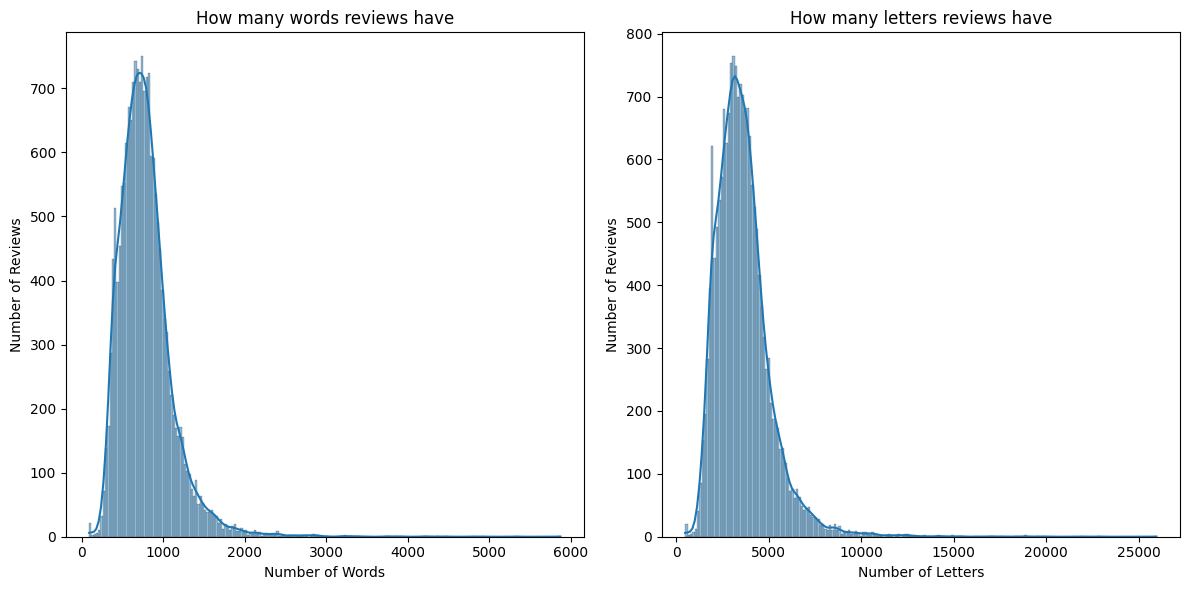

In [16]:
#Creating histograms to visually explore the number of words and characters in reviews

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.histplot(movie_revs['review_words_count'], kde=True, ax=axes[0])
axes[0].set_title('How many words reviews have')
axes[0].set_xlabel('Number of Words')       
axes[0].set_ylabel('Number of Reviews') 

sns.histplot(movie_revs['review_letters_count'], kde=True, ax=axes[1])
axes[1].set_title('How many letters reviews have')
axes[1].set_xlabel('Number of Letters')        
axes[1].set_ylabel('Number of Reviews') 

plt.tight_layout()
plt.show()

The histograms reveal that the distribution of review lengths, measured both by Number of Words and Number of Letters, is strongly right-skewed.

This right-skewed distribution indicates that the majority of reviews are concentrated at the lower end of the length scale. However, the analysis shows a significant density of reviews peaking in the moderate length range (approximately 500–1,000 words and 2,000–4,000 letters).

This high frequency of medium-length reviews is highly beneficial for the NLP model. These reviews are substantial enough to provide rich linguistic context, allowing the model to effectively learn and identify the distinctive patterns that may correlate with the author's gender.

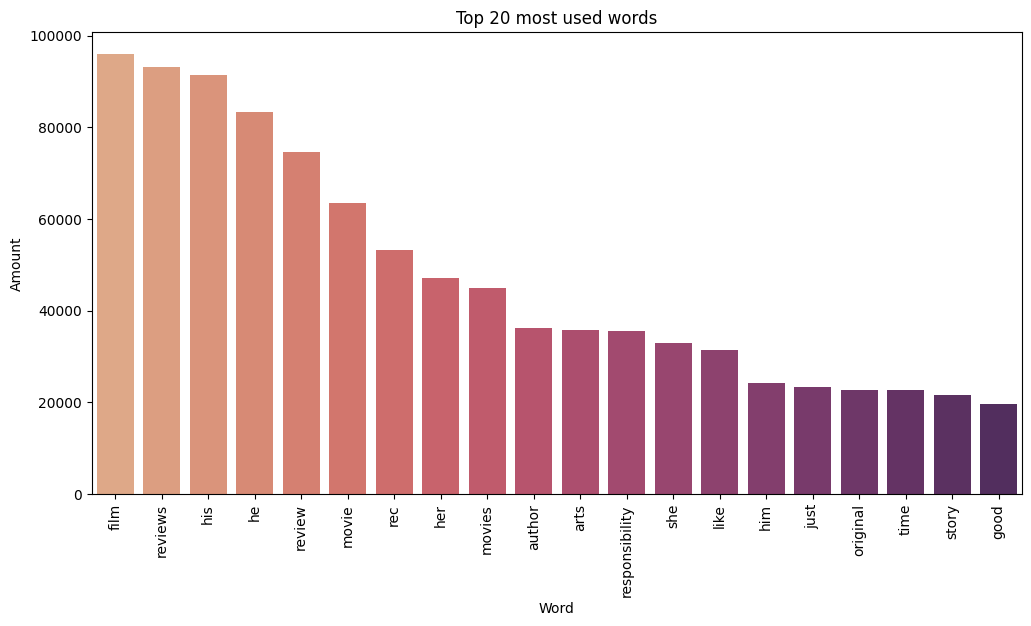

In [17]:
#Removing common stopwords such as 'is', 'am', 'you', 'with', 
#while keeping words that may be helpful for the model
my_stopwords = list(text.ENGLISH_STOP_WORDS)
my_stopwords = [w for w in my_stopwords if w not in ('she', 'he', 'his', 'her', 'him')]

#Creating a vectorizer object ready to transform text into numerical features
vec = CountVectorizer(
    max_features=20,
    stop_words=my_stopwords 
)

#Transforming text into a matrix
matrix = vec.fit_transform(movie_revs['review_text'])

#Summing the counts and getting word names
counts = matrix.sum(axis=0).A1
words = vec.get_feature_names_out()

#Creating DataFrame and sorting
df_words = pd.DataFrame({'Word': words, 'Amount': counts})
df_words = df_words.sort_values('Amount', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(data=df_words, x='Word', y='Amount', hue='Word', palette='flare')
plt.title('Top 20 most used words')
plt.xticks(rotation=90)
plt.show()

This barplot illustrates the top 20 most frequently used words in the dataset after standard English stop words were removed. The most dominant terms are unsurprisingly related to the core subject matter and the critique process, such as "film," "reviews," and "review." Notably, gendered pronouns like "his," "he," "her," and "she" feature prominently in the top 20, suggesting that reviewers frequently refer to individuals (actors, directors, etc.). This high frequency of pronouns is a key finding for the NLP model, as the distribution and context of these terms will likely be crucial in determining the reviewer's gender. Other common words include evaluative and descriptive terms such as "movie," "story," and "good."

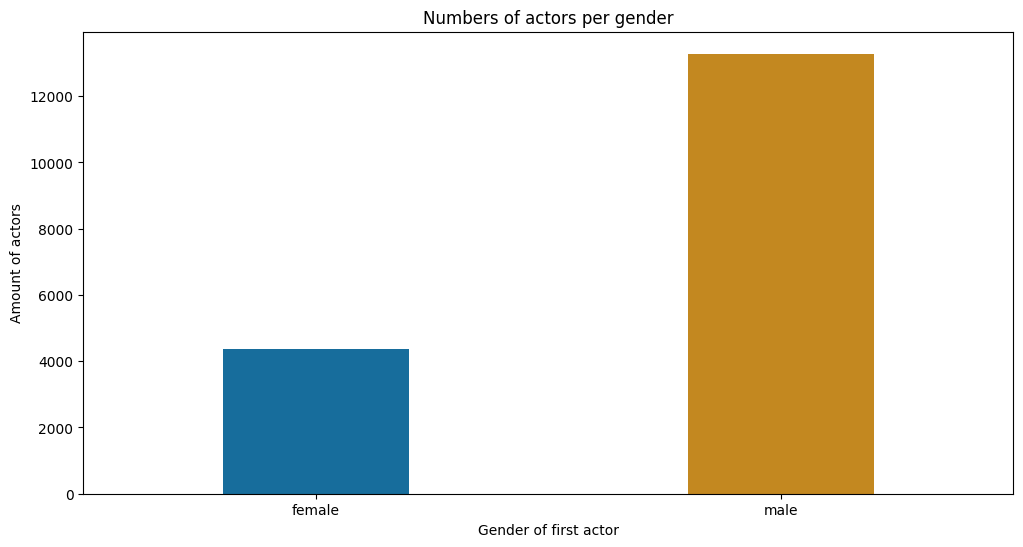

In [18]:
#gender_counter counts how many males and famles are in the dataset
gender_counter = movie_revs.groupby('first_actor_gender').size()

plt.figure(figsize=(12, 6))
sns.barplot(x=gender_counter.index, y=gender_counter.values, hue=gender_counter.index, palette='colorblind', width=0.4)
plt.xlabel('Gender of first actor')
plt.ylabel('Amount of actors')
plt.title('Numbers of actors per gender')
plt.show()

This bar chart visualizes the distribution of the target variable—the gender of the first actor gender—revealing a significant class imbalance. The dataset is heavily dominated by films where the first actor is male - over 12,000 entries. Conversely, the female class is the minority, represented by approximately 4,500 entries. 

This severe imbalance biases the model toward the majority class (male). Therefore, we can't trust standard Accuracy and must use techniques like class weighting and focus on metrics like F1-score and Recall. Additionally, methods such as normalization or scaling should be applied to any numerical features or next to prediction models to ensure no single feature dominates the model due to its magnitude.

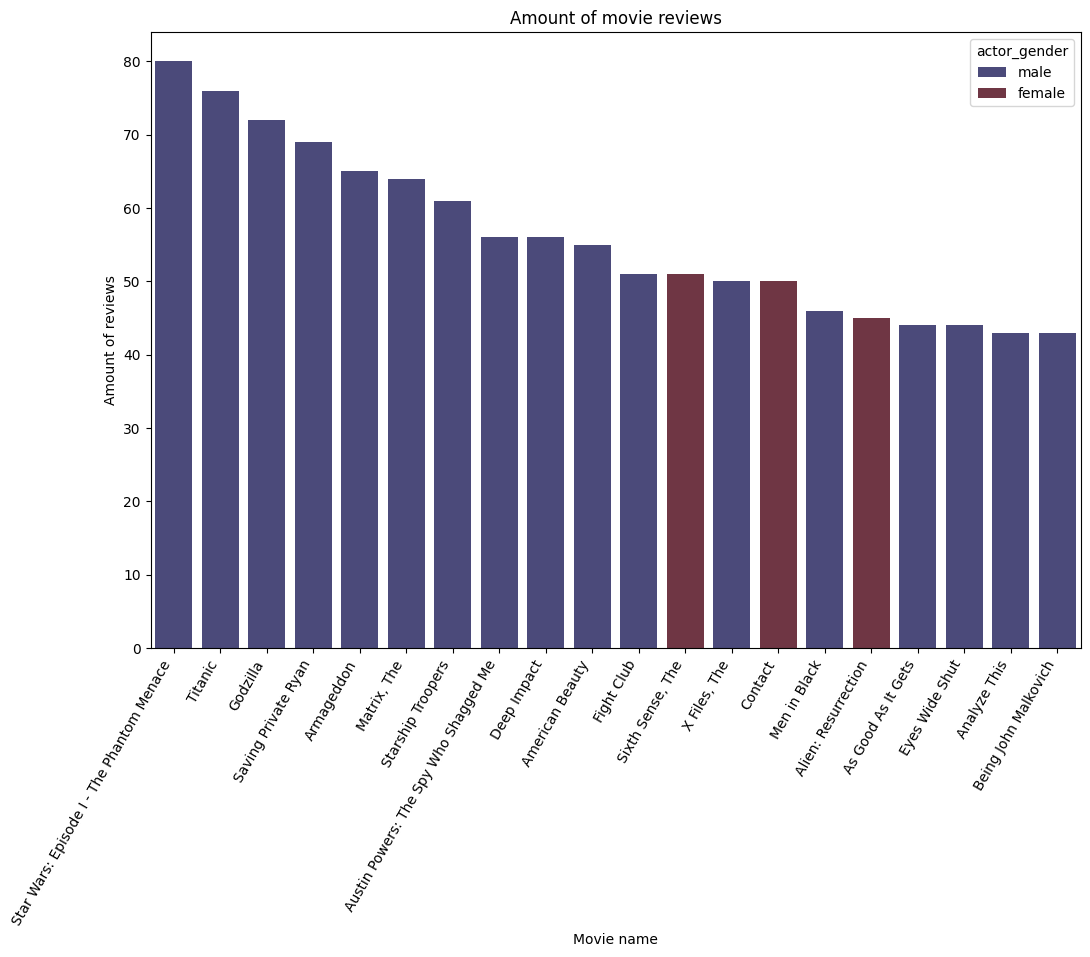

In [19]:
#Counts movie occurrences, sorts them, and retrieves the top 20 films
movie_counter = (
    movie_revs
    .groupby('movie_name')
    .size()
    .sort_values(ascending=False)
    .head(20)
    .reset_index(name='amount')
)

movie_counter.columns = ['movie_name', 'amount']

#For every movie in a movie_counter assign, gender of a first actor
mapping_year = movie_revs.drop_duplicates('movie_name').set_index('movie_name')['first_actor_gender']
movie_counter['actor_gender'] = movie_counter['movie_name'].map(mapping_year)

plt.figure(figsize=(12, 8))
sns.barplot(data=movie_counter, x='movie_name', y='amount', hue='actor_gender', palette='icefire')
plt.xlabel('Movie name')
plt.ylabel('Amount of reviews')
plt.title('Amount of movie reviews')
plt.xticks(rotation=60, ha='right')
plt.show()

The chart lists the top 20 reviewed movies, with "Star Wars: Episode I - The Phantom Menace" leading with 80 reviews. A huge majority of the top-reviewed films prominently feature male first actors, represented by darker bars. There are only three movies, "The X Files", "Contact" and "Allien: Resurrection" where the first actor is female, indicated by the maroon bar. Overall, the visualization demonstrates that movies predominantly featuring a male lead attract a higher volume of reviews in this specific dataset.

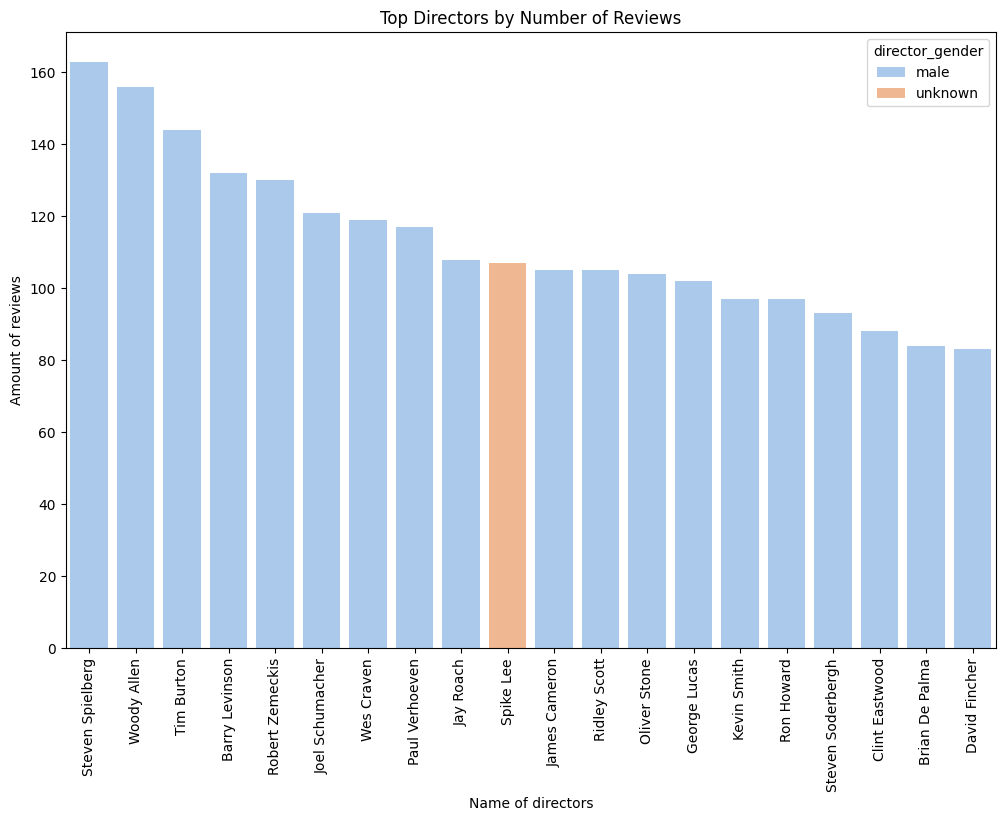

In [20]:
#direct_counter identifies the directors with the highest number of reviews
direct_counter = movie_revs.groupby('first_director').size().sort_values(ascending=False).head(20).reset_index(name='amount')

direct_counter.columns = ['first_director', 'amount']

#For every director in a movie_counter, assign gender
mapping_year = movie_revs.drop_duplicates('first_director').set_index('first_director')['first_director_gender']
direct_counter['director_gender'] = direct_counter['first_director'].map(mapping_year)

plt.figure(figsize=(12, 8))
sns.barplot(data=direct_counter, x='first_director', y='amount', hue='director_gender', palette='pastel')
plt.xlabel('Name of directors')
plt.ylabel('Amount of reviews')
plt.title('Top Directors by Number of Reviews')
plt.xticks(rotation=90)
plt.show()

This bar chart, titled "Top Directors by Number of Reviews" illustrates the number of reviews for the most frequently reviewed directors in the dataset, categorized by gender. The most striking observation is the overwhelming dominance of male directors in terms of review volume, occupying the top ranks. Female directors are significantly underrepresented, appearing only once. This pronounced disparity indicates a strong bias in the dataset towards films directed by men. This visualization strongly suggests that models trying to predict reviewer gender might inadvertently learn this underlying gender imbalance in film production and visibility.

## Model Building

In [21]:
#Setting X and y values for train_test_split
X = movie_revs['revew_text_cleaning']
y = movie_revs['first_actor_gender']

In [22]:
#Train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

In [23]:
#This creates a TF-IDF Vectorizer, a tool that converts text into numerical features
tfidf = TfidfVectorizer(stop_words='english')

#Learning proccess
tfidf.fit(X_train)

#Converting training/test text into sparse matrix
X_train_tfidf = tfidf.transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [24]:
#Setting hyperparameters for future GridSearch
param_grid={
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'nb__alpha': [0.1, 1.0]
}

### First method

The first model tested in this project is the Multinomial Naive Bayes classifier, a fast and effective algorithm commonly used for text classification tasks. It serves as a strong baseline for evaluating how well word-based features can predict the gender of the actor.

In [25]:
#This pipeline first converts text into TF-IDF features and then uses a Multinomial Naive Bayes classifier
pipe = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

In [26]:
#Using GridSearched with our pipe and selected param_grid
grid = GridSearchCV(pipe, param_grid, cv=2, n_jobs=-1, scoring='accuracy')

#Training GridSearch object
grid.fit(X_train, y_train)

,estimator,Pipeline(step...inomialNB())])
,param_grid,"{'nb__alpha': [0.1, 1.0], 'tfidf__ngram_range': [(1, ...), (1, ...)]}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,2
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,input,'content'


In [27]:
print('First model best parameters', grid.best_params_)

First model best parameters {'nb__alpha': 0.1, 'tfidf__ngram_range': (1, 1)}


In [28]:
print('First model best score', grid.best_score_)

First model best score 0.8279866505277964


In [29]:
#Predicting labels of the test set
y_pred = grid.predict(X_test)

print('Accuracy score of the model', accuracy_score(y_test, y_pred))

Accuracy score of the model 0.8717077315208156


#### Classifcation Report and Confusion Matrix for first model

In [30]:
classification_report(y_test, y_pred, output_dict=True)

{'female': {'precision': 0.9927536231884058,
  'recall': 0.47735191637630664,
  'f1-score': 0.6447058823529411,
  'support': 861.0},
 'male': {'precision': 0.8556304138594802,
  'recall': 0.998876404494382,
  'f1-score': 0.9217210990150337,
  'support': 2670.0},
 'accuracy': 0.8717077315208156,
 'macro avg': {'precision': 0.924192018523943,
  'recall': 0.7381141604353443,
  'f1-score': 0.7832134906839874,
  'support': 3531.0},
 'weighted avg': {'precision': 0.8890665745029821,
  'recall': 0.8717077315208156,
  'f1-score': 0.8541736332699015,
  'support': 3531.0}}

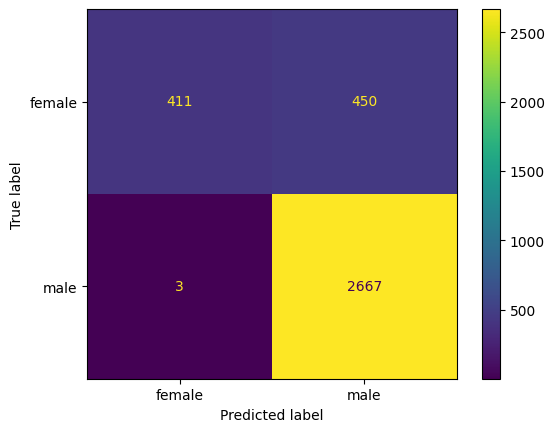

In [31]:
ConfusionMatrixDisplay.from_estimator(grid, X_test, y_test)

The model is highly effective at identifying the majority class ('male') due to its high recall and the underlying data imbalance. However, its performance on the minority class ('female') is unacceptable, with a recall below 50%. The model frequently fails to identify 'female' instances, mistaking them for 'male' (450 False Negatives).

This outcome demonstrates the necessity of mitigating class imbalance — a strategy already planned for Logistic Regression model.

### Second method

The second model applied in this project is Logistic Regression, a widely used linear classifier for binary and multi-class classification. It models the probability of each class based on the input features, providing a strong baseline for predicting the gender of the main actor from review text.

In [32]:
#Creating LabelEncoder to convert categorical labels into numeric form
le = LabelEncoder()
y_numeric_types = le.fit_transform(y)

In [33]:
#Creating a Logistic Regression classifier object, 
#class_weight='balanced' adjusts the weights inversely proportional to class frequencies
log_reg_model = LogisticRegression(class_weight='balanced')

In [34]:
log_reg_model.fit(X_train_tfidf, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [35]:
#using the trained Logistic Regression model to make predictions on the test set
log_pred_num = log_reg_model.predict(X_test_tfidf)

In [36]:
print('Accuracy score of the model', accuracy_score(y_test, log_pred_num))

Accuracy score of the model 0.9340130274709714


#### Classifcation Report and Confusion Matrix for second model

In [37]:
classification_report(y_test, log_pred_num, target_names=le.classes_, output_dict=True)

{'female': {'precision': 0.8427947598253275,
  'recall': 0.8966318234610917,
  'f1-score': 0.8688801350590883,
  'support': 861.0},
 'male': {'precision': 0.9659655831739962,
  'recall': 0.946067415730337,
  'f1-score': 0.9559129612109745,
  'support': 2670.0},
 'accuracy': 0.9340130274709714,
 'macro avg': {'precision': 0.9043801714996618,
  'recall': 0.9213496195957144,
  'f1-score': 0.9123965481350313,
  'support': 3531.0},
 'weighted avg': {'precision': 0.9359315761212622,
  'recall': 0.9340130274709714,
  'f1-score': 0.9346908532198178,
  'support': 3531.0}}

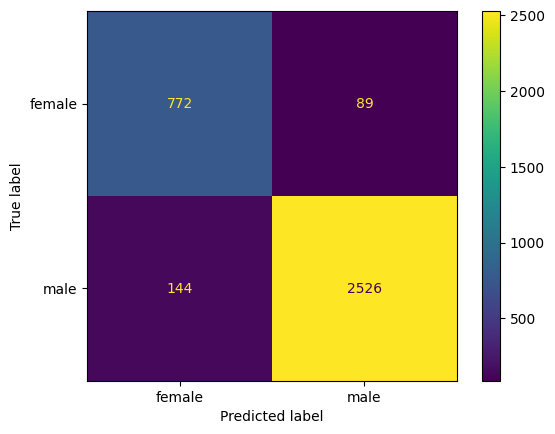

In [38]:
ConfusionMatrixDisplay.from_predictions(y_test, log_pred_num, display_labels=['female', 'male'])

The second model is vastly superior for this classification task. By implementing class weighting (likely the reason for the improvement), the model shifted its focus from simply minimizing total errors (biased by the majority class) to minimizing errors on the minority class, resulting in a balanced and robust predictive performance across both genders.
The model successfully predicted gender better for the female class, but the performance metrics for the male class are slightly worse compared to the first model.

### Third method

The third model applied in this project is Linear Support Vector Classification (LinearSVC), a linear classifier that aims to find the hyperplane which best separates classes in the feature space. LinearSVC is effective for high-dimensional data such as TF-IDF representations of text and can serve as a strong alternative to Logistic Regression for predicting the gender of the main actor.

In [47]:
#Creating LinearSVC object
svc_model = LinearSVC(max_iter=5000)

In [48]:
#Setting most important hyperparameters for future GridSearch
param_grid_svc = {
    'C': [0.1, 0.5, 1.0, 2.0],
    'penalty': ['l2'],
    'loss': ['hinge', 'squared_hinge']
}

In [49]:
grid_svc = GridSearchCV(svc_model, param_grid_svc)

In [50]:
#Training the GridSearchCV object for the LinearSVC model on the training data
grid_svc.fit(X_train_tfidf, y_train)

,estimator,LinearSVC(max_iter=5000)
,param_grid,"{'C': [0.1, 0.5, ...], 'loss': ['hinge', 'squared_hinge'], 'penalty': ['l2']}"
,scoring,None
,n_jobs,None
,refit,True
,cv,None
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,penalty,'l2'


In [57]:
#Making predictions on the test set using the TF-IDF feature matrix
y_pred_svc = grid_svc.predict(X_test_tfidf)

In [58]:
print('Best parameters', grid_svc.best_params_)
print('Best score', grid_svc.best_score_)

Best parameters {'C': 2.0, 'loss': 'hinge', 'penalty': 'l2'}
Best score 0.9470285040988744


In [59]:
print('Accuracy score', accuracy_score(y_test, y_pred_svc))

Accuracy score 0.9532710280373832


#### Classifcation Report and Confusion Matrix for thrid model

In [61]:
classification_report(y_test, y_pred_svc, output_dict=True)

{'female': {'precision': 0.9371859296482412,
  'recall': 0.8664343786295006,
  'f1-score': 0.9004224502112251,
  'support': 861.0},
 'male': {'precision': 0.9579524680073126,
  'recall': 0.9812734082397003,
  'f1-score': 0.969472710453284,
  'support': 2670.0},
 'accuracy': 0.9532710280373832,
 'macro avg': {'precision': 0.9475691988277769,
  'recall': 0.9238538934346004,
  'f1-score': 0.9349475803322546,
  'support': 3531.0},
 'weighted avg': {'precision': 0.952888749647879,
  'recall': 0.9532710280373832,
  'f1-score': 0.9526354762226374,
  'support': 3531.0}}

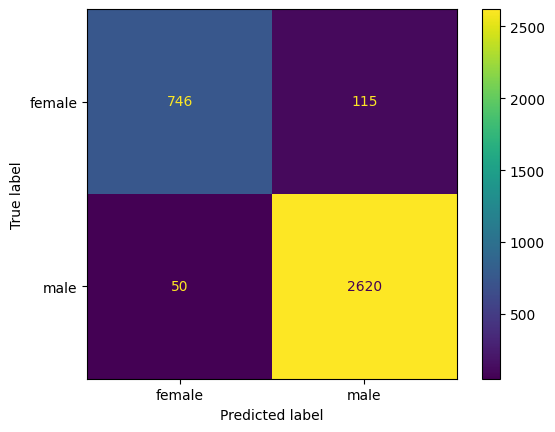

In [62]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_svc, display_labels=['female', 'male'])

The third model shows the best overall performance with an accuracy of 95.33%. It maintains strong results on the majority class while providing noticeably better precision on the minority class compared to Model 2. Overall, this model offers the most optimal balance for predicting the gender of main actors, significantly improving female precision and male recall, ultimately achieving the highest accuracy among all tested models.

## Conclusion

The project successfully classified the gender of the main actor—a proxy for the film’s primary subject—based solely on the associated movie review text. The main challenge encountered was a significant class imbalance in the target variable, which initially skewed model performance. The first model (Multinomial Naive Bayes) struggled with this issue, achieving a Female Recall of only 47.74% despite a seemingly strong overall accuracy of 87.17%. To address this limitation, the subsequent Logistic Regression model applied class weighting, which significantly improved Female Recall to 89.66% and effectively increased accuracy score.

The final stage involved tuning an optimized Linear Support Vector Classification model, which delivered the best overall balance and performance. This model achieved the highest accuracy of 95.33%, along with a strong Female F1-score of 90.04%.

Overall, the project demonstrates that advanced NLP methods can accurately predict gender-related characteristics in movie reviews, provided that class imbalance is addressed strategically through techniques such as class weighting, text preprocessing, or hyperparameter tuning.